# Integrantes do grupo
Bruno dos Santos, **NUSP 10786170**

Henrique de S. Q. dos Santos, **NUSP 10819029**

Paulo H. da Silva, **NUSP 10734515**

Witor M. A. de Oliveira, **NUSP 10692190**

# Descrição do Problema
Abaixo, definimos a função objetivo, as restrições e variáveis do modelo.

Função objetivo: $\min z = \sum_{(i,j) \in G}^{}(D_{ij} \times x_{ij})$

Sujeito a:

- (1) $\space$ $x_{ij} \in \{0,1\}, \forall i,j \in G$

- (2) $\space$ $\sum_{i \neq j} x_{i,j} = 1 \space \forall j$

- (3) $\space$ $\sum_{j \neq i} x_{i,j} = 1 \space \forall i$

- (4) $\space$ $u_{i}-u_{j} \leq  N(1-x_{i,j}) - 1 \space\space \text{(Formulação de Miller, Tucker e Zemlin (MTZ))}$

<!-- - (5) $D_{ii} = M, i = 0,...,N$ -->

Onde:

- $D_{ij} = \text {custo (dado pela distância euclideana) de visitar a galáxia $j$ a partir de $i$}$
- $x_{ij} = 1 \text{, se a aresta $(i,j)$ for escolhida como caminho}$;
- $x_{ij} = \text{0, caso contrário}$;
- $u_{i} = \text{ordem que a cidade i é visitada}$;
- $N = \text{número de cidades}$;
- $G = \text{conjunto de cidades}$;
<!-- - $M = \text{é um valor inteiro suficientemente grande}$; -->

Referências:

[1] Temel Öncan, İ. Kuban Altınel, Gilbert Laporte, ***A comparative analysis of several asymmetric traveling salesman problem formulations***, *Computers & Operations Research*, Volume 36, Issue 3, 2009, Pages 637-654, ISSN 0305-0548, https://doi.org/10.1016/j.cor.2007.11.008;

[2] Keld Helsgaun, ***An effective implementation of the Lin–Kernighan traveling salesman heuristic***, European Journal of Operational Research, Volume 126, Issue 1, 2000, Pages 106-130, ISSN 0377-2217, https://doi.org/10.1016/S0377-2217(99)00284-2;

[3] Pferschy, U., Staněk, R. ***Generating subtour elimination constraints for the TSP from pure integer solutions***. Cent Eur J Oper Res 25, 231–260 (2017). https://doi.org/10.1007/s10100-016-0437-8;


# Implementação

Instalação do **[OR-Tools](https://developers.google.com/optimization/introduction/overview)**

In [106]:
pip install --upgrade --user ortools

Requirement already up-to-date: ortools in /root/.local/lib/python3.6/site-packages (8.0.8283)


Instalação da biblioteca [ELKAI](https://github.com/filipArena/elkai) que implementa o [LKH](http://akira.ruc.dk/~keld/research/LKH/), uma versão da heurística [Lin-Kernighan](https://en.wikipedia.org/wiki/Lin%E2%80%93Kernighan_heuristic) proposta por K. Helsgaun.

In [107]:
pip install elkai

Importando alguns módulos necessários pra execução do código.

In [108]:
import elkai # LKH heuristic
import numpy as np
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from sklearn.metrics.pairwise import euclidean_distances

Permitindo acesso ao Google Drive.
Necessário quando você pretende ler o arquivo com os dados do TSP a partir do seu drive.

In [109]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [110]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Leitura dos dados a partir de arquivos **.tsp**, padrão dos arquivos disponibilizados em [Uwaterloo](http://www.math.uwaterloo.ca/tsp/world/countries.html).

In [111]:
nodes = []

# path = 'National TSPs/wi29.tsp' # WESTERN SAHARA DATASET
# city = 'Western Sahara'

path = 'National TSPs/dj38.tsp' # DJIBOUTI DATASET
city = 'Djibouti'

# path = 'National TSPs/qa194.tsp' # QATAR DATASET
# city = 'Qatar'

# path = 'National TSPs/uy734.tsp' # URUGUAY DATASET
# city = 'Uruguai'

# Opens input file
with open('/content/drive/MyDrive/'+path, 'r') as f:
    for line in f:
        if "DIMENSION" in line:
            Dimension = int(''.join(filter(str.isdigit, line)))
        elif "NODE_COORD_SECTION" in line:
            for i in range(Dimension):
                read_line = f.readline()
                if len(read_line) > 0:
                    x,y = read_line.strip().split()[1:]
                    nodes.append([float(x), float(y)])

# Close input file
f.close() 

# Transform into a np array
G = np.asarray(nodes)

# G = np.asarray([(4,5), (7,4), (6,2), (1,3), (2,0)])
# city = 'Problema Amostra'

# print(G)

Representação gráfica do conjunto de cidades

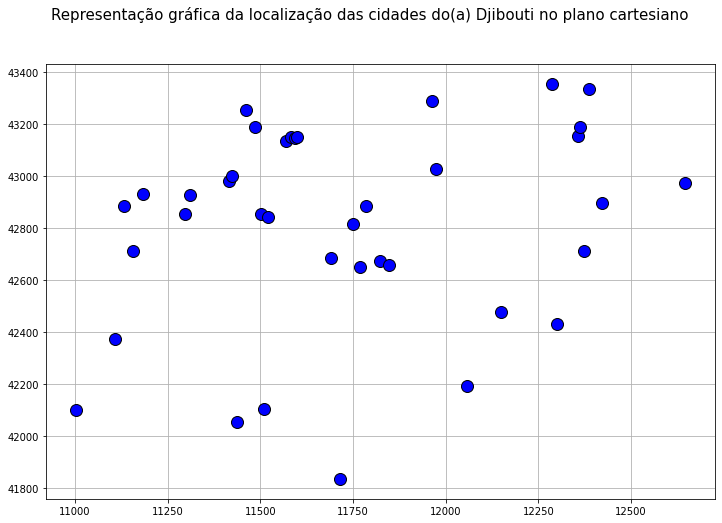

In [112]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(G[:,0], G[:,1], color="none",  marker='o', markerfacecolor='blue', markersize=12)

fig.suptitle('Representação gráfica da localização das cidades do(a) ' + city + ' no plano cartesiano', fontsize=15) 
ax.grid(True)

plt.show()

Cálculo dos custos das distâncias entre cada cidade no conjunto

In [113]:
# Esse vetor guarda inteiros que servem como 'id's das cidades.
cidades = [i for i in range(len(G))]

# Calcula a matriz de custos dada pela dist. euclideana entre as cidadas.
cost = euclidean_distances(G)

cost = np.round(cost)

# Restrição 5
# np.fill_diagonal(cost, float("inf"))

distances = dict(((a,b), cost[a][b]) for a in range(len(G)) for b in range(len(G)) if a!=b)

Cálculo da heurística LKH

In [114]:
# best_route = elkai.solve_int_matrix(cost)

# print("Melhor rota: " + str(elkai.solve_int_matrix(cost)))

Cálculo da heurística 2-opt

Source: https://stackoverflow.com/a/53977320/10304974

In [127]:
def cost_change(cost_mat, n1, n2, n3, n4):
    return cost_mat[n1][n3] + cost_mat[n2][n4] - cost_mat[n1][n2] - cost_mat[n3][n4]

def two_opt(route, cost_mat):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route)):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue
                if cost_change(cost_mat, best[i - 1], best[i], best[j - 1], best[j]) < 0:
                    best[i:j] = best[j - 1:i - 1:-1]
                    improved = True
    return best

nodes = len(G)

init_route = list(range(nodes))
init_route.append(0)
best_route = two_opt(init_route, list(cost))

print(best_route)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 0]
[0, 1, 3, 2, 4, 5, 6, 10, 11, 16, 17, 18, 15, 8, 7, 12, 14, 19, 22, 25, 24, 21, 23, 27, 26, 30, 35, 33, 32, 37, 36, 34, 31, 29, 28, 20, 13, 9, 0]
[0, 1, 3, 2, 4, 5, 6, 10, 11, 16, 17, 18, 15, 8, 7, 12, 14, 19, 22, 25, 24, 21, 23, 27, 26, 30, 35, 33, 32, 37, 36, 34, 31, 29, 28, 20, 13, 9, 0]


In [116]:
# Essa matriz guardará as arestas que pertencem ao caminho dado pela heurística.
# Se o caminho dado for 0,1,2,0, as posições (0,1), (1,2), (2,0)
# terão seu valor igual a um.
init_tour = np.zeros((len(G),len(G)), dtype=np.int64)

for i in range(len(best_route)-1):
  init_tour[best_route[i]][best_route[i+1]] = 1

Criação das variáveis e restrições descritas na modelagen. 

In [117]:
# Cria o solver de MIP com o SCIP
solver = pywraplp.Solver.CreateSolver('SCIP')

solver.SetTimeLimit(600000) # 10 min (tempo em millisegundos)
# solver.SetTimeLimit(1800000) # 30 min (tempo em millisegundos)
# solver.SetTimeLimit(3600000) # 1 hr (tempo em millisegundos)

In [118]:
# Esse dicionário guardará, como chaves, as posições (i,j) que indicam
# se uma aresta entre as cidades 'i' e 'j' pertence ao caminho encontrado.
x = {}

# Restrição 1
for i in range(len(G)):
    for j in range(len(G)):
        if i != j:
            x[i,j] = solver.IntVar(0, 1, 'x_'+str(i)+"_"+str(j))
            solver.Add(0 <= x[i,j] <= 1, 'x_'+str(i)+"_"+str(j))

Calculando um chute inicial.

A partir do resultado retornado pela heurística, preparamos os dados para utilizarmos como um chute/solução inicial pro solver partir. Isso pode melhorar (ou piorar) ou não o desempenho do solver.

In [119]:
vars = solver.variables()
values = [0 for i in range(len(vars))]
indice = 0

for i in range(len(init_tour)):
    for j in range(len(init_tour)):
        if i!=j and init_tour[i][j] == 1:
            indice = x[i,j].index()
            values[indice] = 1

solver.SetHint(vars, values)

In [120]:
# Restrições 2 e 3
for j in cidades:
    solver.Add(solver.Sum([ x[(i,j)] for i in cidades if (i,j) in x]) == 1)
    solver.Add(solver.Sum([ x[(j,i)] for i in cidades if (j,i) in x]) == 1)

Eliminação de subcaminhos.

Utilizamos a Formulação de Miller, Tucker e Zemlin

In [121]:
# Restrição 4
u = {}

for i in range(len(cidades)):
    u[i] = solver.IntVar(0,len(cidades), 'u_'+str(i))

left = 0
right = 0
for i in cidades:
    for j in cidades:
        if i != j and (i != 0 and j != 0) and (i,j) in x:
            left = u[i] - u[j]
            right = len(cidades)*(1 - x[(i,j)]) - 1
            solver.Add(left <= right, 'U_'+str(i))

Definição a função objetivo

In [122]:
solver.Minimize(solver.Sum(x[(i,j)] * distances[(i,j)] for (i,j) in distances))

Resolução do problema

In [123]:
solver.EnableOutput()
%time status = solver.Solve()

CPU times: user 3min 11s, sys: 455 ms, total: 3min 11s
Wall time: 3min 11s


Exibição gráfica do resultado encontrado pelo *Solver*

In [124]:
# Variáveis utilizadas pra fazer o parsing no nome das variáveis
inicio = 0
novo_inicio = 0
fim = 0
novo_fim = 0

# Variáveis utilizadas pra construir uma string com o caminho encontrado pelo solver
ultimo = ""
string = ""
aux = 0
j = 0

pontosEmOrdem = []

while j < aux + (len(G)-1):
  nome = str(vars[j].name)

  if vars[j].solution_value(): 
    inicio = nome.find("_")
    fim = nome.find("_", inicio+1, len(nome))

    novo_inicio = fim + 1
    novo_fim = nome.find(">")

    # print(nome[inicio+1:fim] + " -> " + nome[novo_inicio:novo_fim])
    string += nome[inicio+1:fim] + " -> "
    pontosEmOrdem.append(G[int(nome[inicio+1:fim])])
    ultimo = nome[novo_inicio:novo_fim] 

    aux = int(ultimo)*(len(G)-1)
    j = aux

    if ultimo == '0':
      string += ultimo
      break

  else:
    j = j+1

# Mostrando caminho percorrido
# print(string)

pontosEmOrdem.append(G[0])

x = []
y = []

for i in range(len(pontosEmOrdem)):
  x.append(pontosEmOrdem[i][0])
  y.append(pontosEmOrdem[i][1])
#   print(pontosEmOrdem[i], "x: ", x[i], "y: ", y[i])

for i in range(len(x)):
  x[i] = float(x[i])
  y[i] = float(y[i])

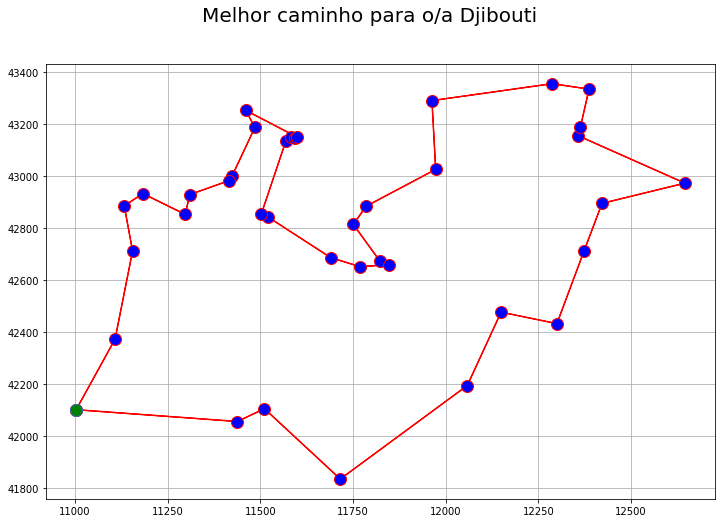

In [125]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(x, y, color="red",  marker='o', markerfacecolor='blue', markersize=12)
for i in range(len(x)):
  if i == len(x)-1:
    plt.arrow(x[i], y[i], x[i]-x[0], y[i]-y[0], head_width=0.2, width=0.025, fc='r', ec='r', length_includes_head=True)
  else: 
    plt.arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i], head_width=0.2, width=0.025, fc='r', ec='r', length_includes_head=True)

plt.plot(x[0], y[0], marker='o', markerfacecolor='green', markersize=12)

fig.suptitle('Melhor caminho para o/a ' + city, fontsize=20) 
ax.grid(True)

plt.show()

Exibição dos resultados.

In [126]:
if status == pywraplp.Solver.FEASIBLE:
    print("Finalizou sem encontrar a solução ótima.")

if status == pywraplp.Solver.OPTIMAL:
    print("Solução ótima encontrada.")

elif status == pywraplp.Solver.NOT_SOLVED:
    print("Solução não encontrada no tempo limite.")

elif status == pywraplp.Solver.INFEASIBLE:
    print("Problema inviável.")

print('Valor da função objetivo =', round(solver.Objective().Value(), 2))
print('Número de nós visitados durante o B&B =', solver.nodes())
print('Problema resolvido em %f milisegundos' % solver.wall_time())
print('Problema resolvido em %d iterações' % solver.iterations())

Solução ótima encontrada.
Valor da função objetivo = 6656.0
Número de nós visitados durante o B&B = 13923
Problema resolvido em 191839.000000 milisegundos
Problema resolvido em 269659 iterações


# Resultados

- Western (29 cidades)
    - Uwaterloo: 27.603
    - 2-opt:
        - 35.436,42 10min (solucao ótima)
            - Nós visitados: 62521
    - LKH:
        - 28.897,34 10min (nao é a solucao ótima)
            - Nós visitados: 50871

- Djibouti (38 cidades)
    - Uwaterloo: 6.656
    - 2-opt:
        - 6.659,43 10 min (nao é a solucao ótima)
        - Nós visitados: 40214
    - LKH:
        - 6.659,43 10 min de limite, ex. em 2min (solução ótima)
        - Nós visitados: 10545

- Qatar (194 cidades)
    - Uwaterloo: 9.352
    - 2opt:
        - O nosso: 60.564 10min (não é solução ótima)
            - Nós visitados: 10
        - O nosso: 11.181,91 30min (não é solução ótima)
            - Nós visitados: 35
        - O nosso: 11.181,91 1hr (não é solução ótima)
            - Nós visitados: 146
    - LKH:
        - 39.661,12 10min (não é a ótima)
            - Nós: 7
        - 39.661,12 20min (não é a ótima)
            - Nós: 36

- Uruguay (734 cidades)
    - Uwaterloo: 79.114
    - O nosso: 91.163,86 com LKH
    - 88.326,77 2-opt (não é a solução ótima)
    - 843.853 sem dica
    - Nós visitados: 1